In [1]:
import pandas as pd
from matplotlib import pyplot as py
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [2]:
df = pd.read_excel("premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
df.shape

(50000, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [7]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

### Handle NA Value

In [9]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [10]:
df.shape

(49976, 13)

In [13]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [18]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1])

In [19]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [25]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

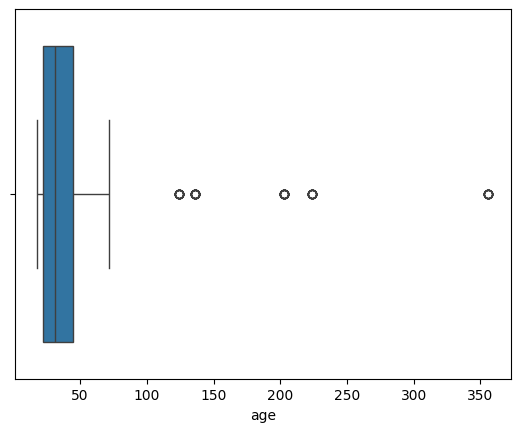

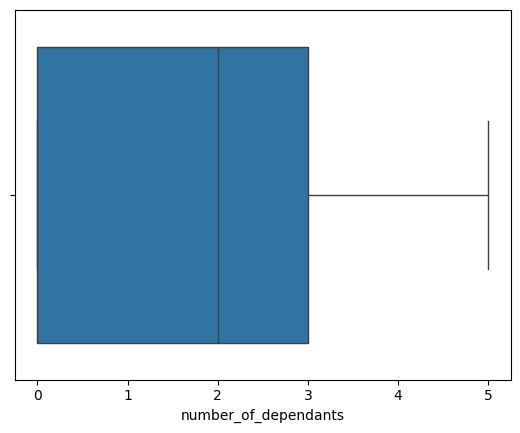

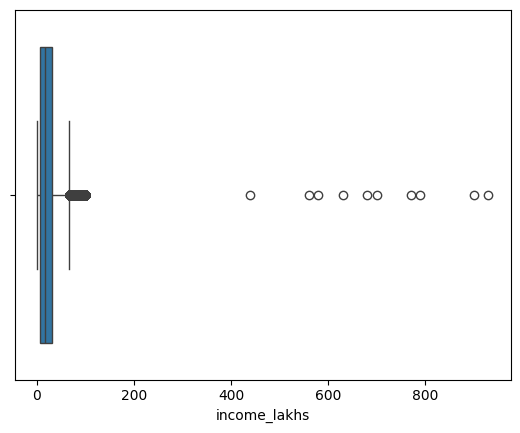

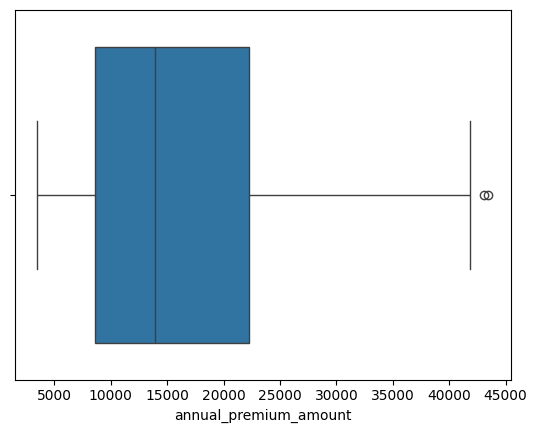

In [26]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    py.show()

In [27]:
df[df.age>100].shape

(58, 13)

In [30]:
df[df.age>100]["age"].unique()

array([224, 124, 136, 203, 356])

In [32]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [34]:
df.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [35]:
def get_iqr_bonds(col1):
    Q1,Q3 = df.income_lakhs.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5* IQR
    return lower_bound,upper_bound

In [40]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [121]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


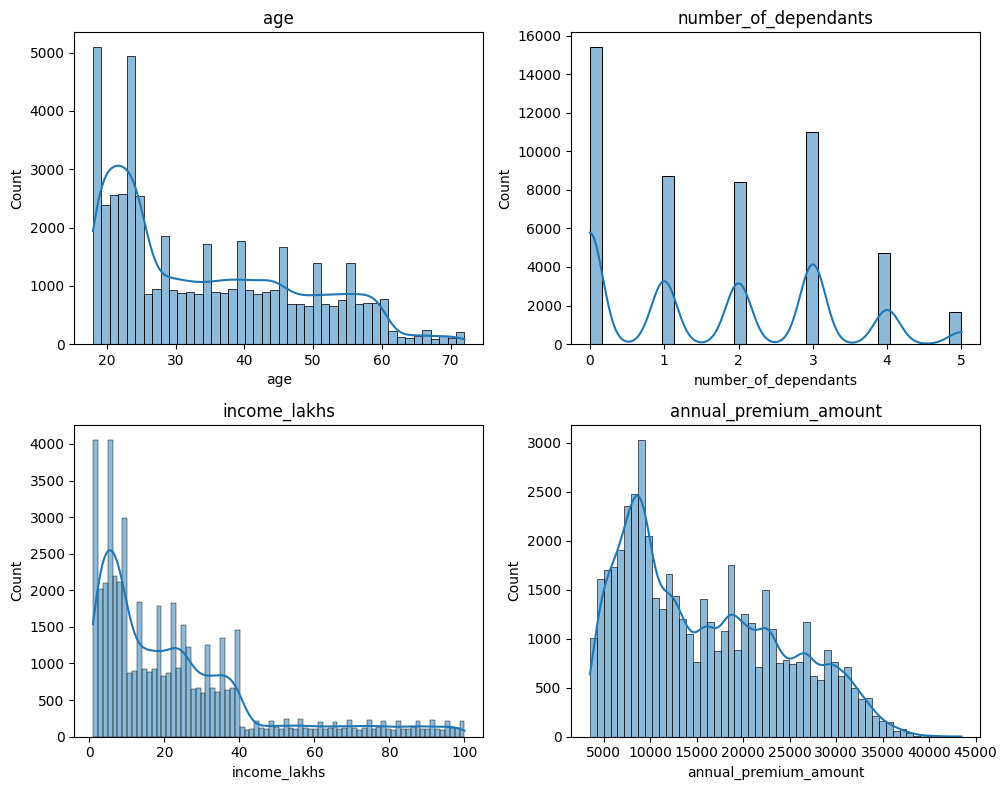

In [122]:
fig,axs = py.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_columns):
    ax = axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)

py.tight_layout()
py.show()

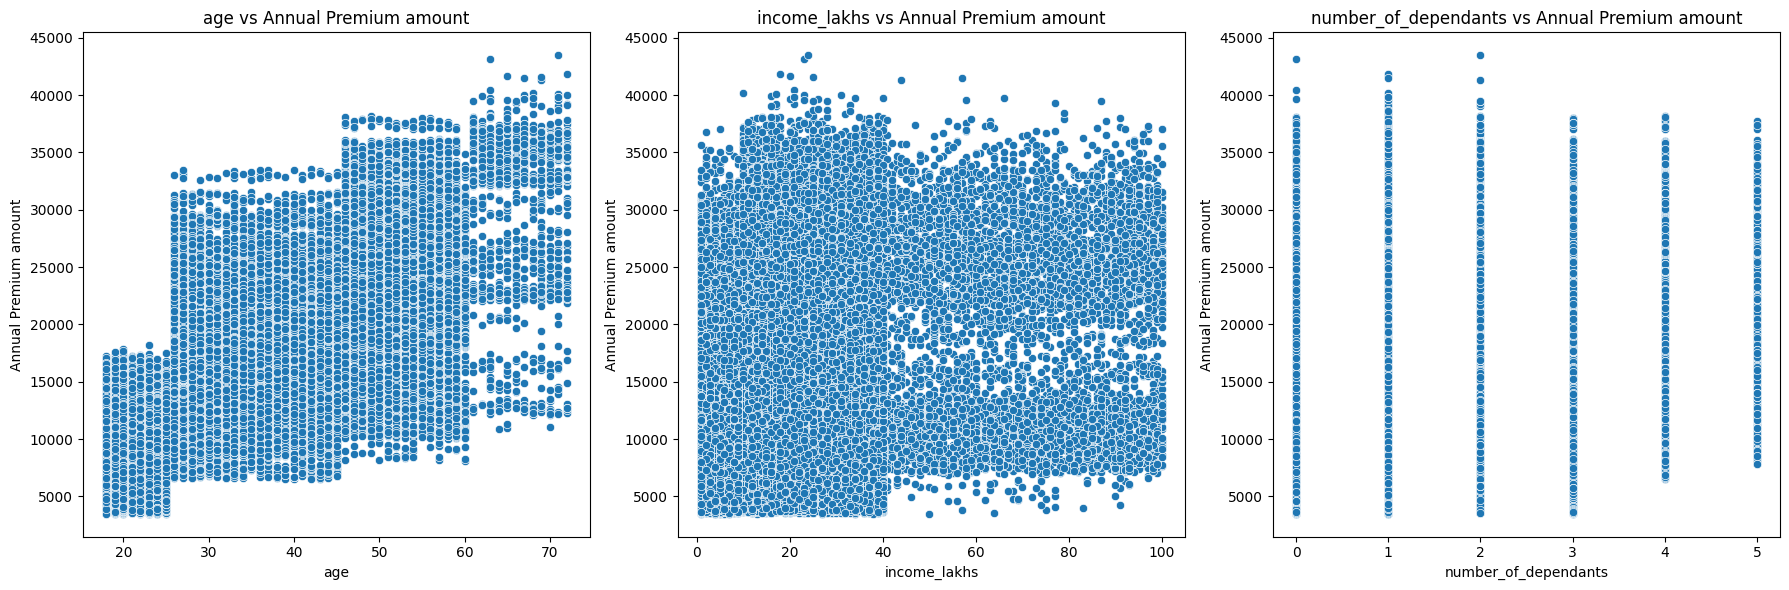

In [123]:
numeric_features = ["age","income_lakhs","number_of_dependants"]

fig,axes = py.subplots(1,len(numeric_features),figsize=(18,6))

for ax,column in zip(axes,numeric_features):
    sns.scatterplot(x=df2[column],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f"{column} vs Annual Premium amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium amount")

py.tight_layout()
py.show()

In [124]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [125]:
df2["smoking_status"].replace({
    'Smoking=0':"No Smoking",
    "Not Smoking":'No Smoking',
    "Does Not Smoke":"No Smoking"
},inplace=True)

df2["smoking_status"].unique()

C:\Users\91999\AppData\Local\Temp\ipykernel_25408\2825346143.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [126]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [127]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

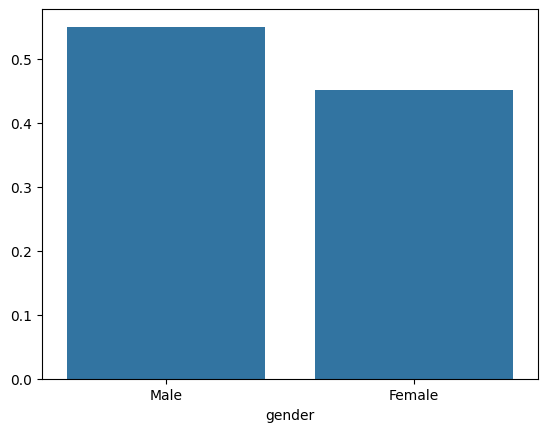

In [128]:
sns.barplot(x=pct_count.index,y=pct_count.values)
py.show()

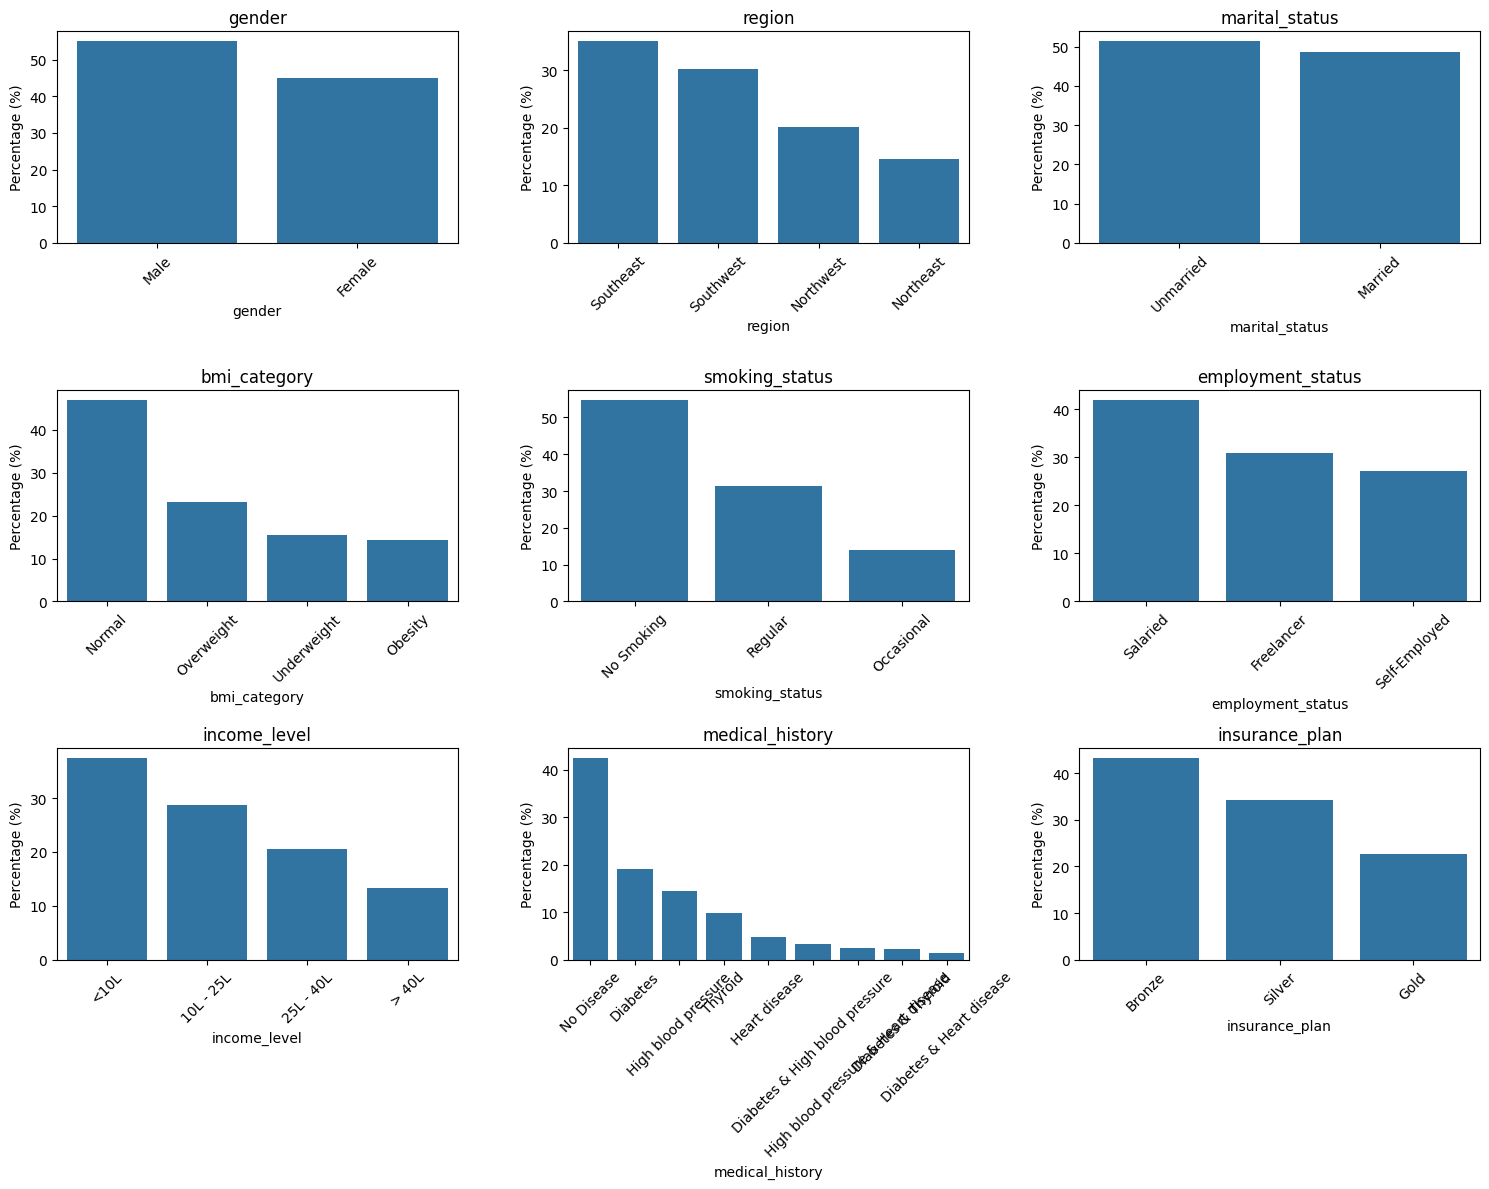

In [129]:
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # ensures enough rows

fig, axes = py.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten in case of extra axes

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    pct_count = df2[col].value_counts(normalize=True) * 100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(col)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove any unused subplots
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

py.tight_layout()
py.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


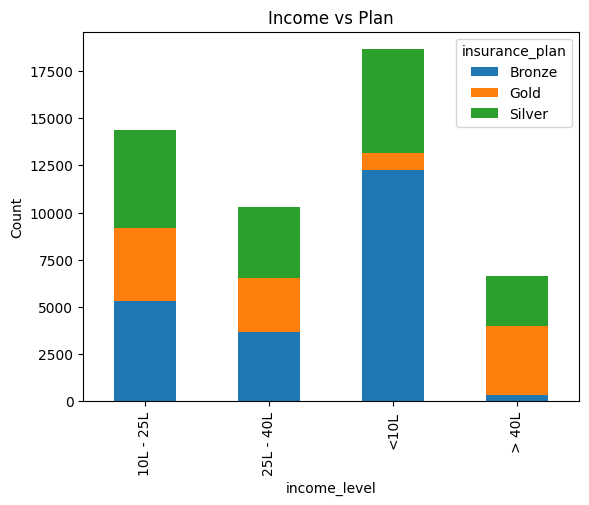

In [130]:
crosstab = pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(crosstab)

crosstab.plot(kind="bar",stacked=True)
py.title("Income vs Plan")
py.ylabel('Count')
py.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

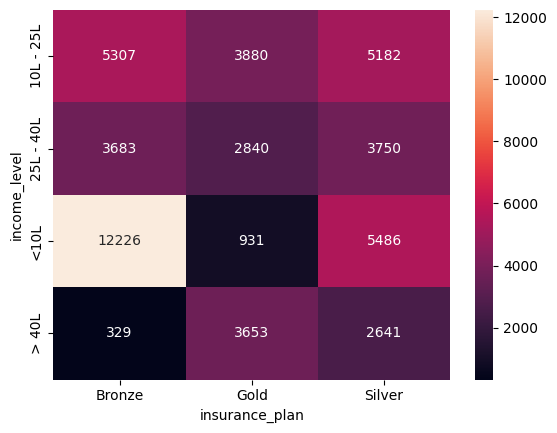

In [131]:
sns.heatmap(crosstab,annot=True,fmt="d")

In [132]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [133]:
df2["medical_history"].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [134]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[["disease1","disease2"]] = df2["medical_history"].str.split(" & ",expand=True).apply(lambda x:x.str.lower())
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,no disease,None
49996,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076,thyroid,None
49997,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,no disease,None
49998,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,9490,no disease,None


In [135]:
df2["disease1"].fillna("none",inplace=True)
df2["disease2"].fillna("none",inplace=True)
df2["total_risk_score"] = 0

for disease in ["disease1","disease2"]:
    df2["total_risk_score"] += df2[disease].map(risk_scores)

max_score = df2["total_risk_score"].max()
min_score = df2["total_risk_score"].min()

df2["normalized_risk_score"] = (df2["total_risk_score"]-min_score)/(max_score-min_score)
df2.head(5)

C:\Users\91999\AppData\Local\Temp\ipykernel_25408\2819023519.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none",inplace=True)
C:\Users\91999\AppData\Local\Temp\ipykernel_25408\2819023519.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [136]:
df2.iloc[42318]

age                                 26
gender                            Male
region                       Southwest
marital_status                 Married
number_of_dependants                 3
bmi_category                    Normal
smoking_status              No Smoking
employment_status           Freelancer
income_level                      <10L
income_lakhs                         7
medical_history          Heart disease
insurance_plan                  Bronze
annual_premium_amount            12959
disease1                 heart disease
disease2                          none
total_risk_score                     8
normalized_risk_score         0.571429
Name: 42400, dtype: object

In [137]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
12157,36,Male,Southeast,Married,2,Overweight,Regular,Self-Employed,<10L,2,Diabetes & High blood pressure,Gold,28687,diabetes,high blood pressure,12,0.857143
8120,45,Male,Northwest,Married,3,Overweight,No Smoking,Salaried,<10L,1,Heart disease,Bronze,15647,heart disease,none,8,0.571429
44874,19,Male,Southeast,Unmarried,0,Normal,Regular,Freelancer,10L - 25L,17,Diabetes & Thyroid,Bronze,7298,diabetes,thyroid,11,0.785714
15220,19,Female,Northwest,Unmarried,0,Normal,Regular,Freelancer,<10L,9,No Disease,Silver,13436,no disease,none,0,0.000000
47730,43,Male,Southeast,Unmarried,1,Overweight,Regular,Freelancer,25L - 40L,30,Diabetes,Silver,20209,diabetes,none,6,0.428571
28295,18,Male,Northeast,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,28,No Disease,Bronze,4962,no disease,none,0,0.000000
31615,48,Male,Southwest,Married,2,Overweight,Occasional,Salaried,10L - 25L,18,High blood pressure,Gold,30024,high blood pressure,none,6,0.428571
34127,53,Female,Southeast,Married,2,Normal,No Smoking,Self-Employed,<10L,6,High blood pressure,Silver,18601,high blood pressure,none,6,0.428571
12522,25,Female,Northeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,10,No Disease,Bronze,7115,no disease,none,0,0.000000
26586,20,Male,Southeast,Married,3,Overweight,Occasional,Salaried,10L - 25L,22,No Disease,Bronze,6126,no disease,none,0,0.000000


In [138]:
df2["insurance_plan"] = df2["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [139]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [142]:
df2["income_level"] = df2["income_level"].map({'<10L':1,'10L - 25L':2,'25L - 40L':3,'> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [146]:
nominal_cols = ["gender","region","marital_status","bmi_category","smoking_status","employment_status"]

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [147]:
df4 = df3.drop(["disease1","disease2","medical_history","total_risk_score"],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


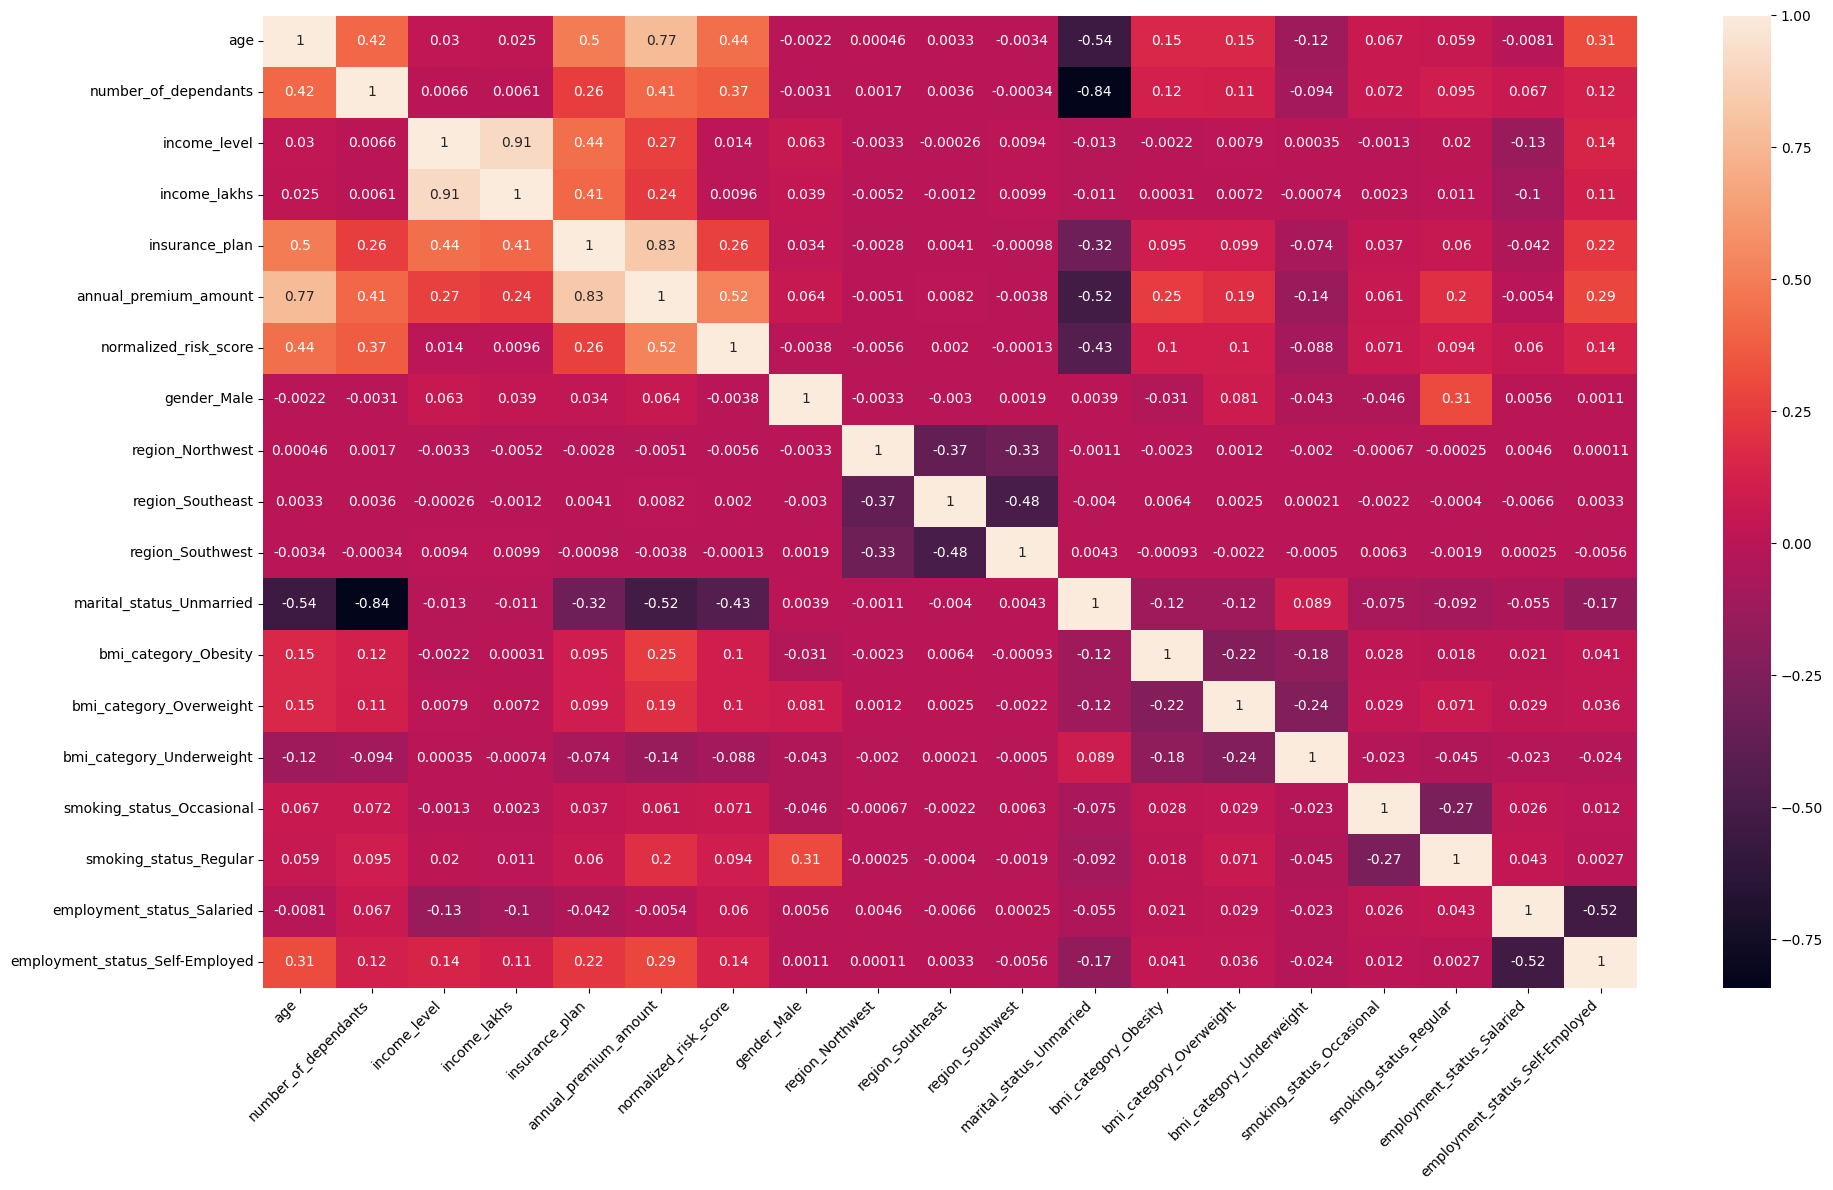

In [151]:
cm = df4.corr()

py.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
py.xticks(rotation=45,ha="right")
py.yticks(rotation=0)
py.tight_layout()
py.show()

In [153]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [154]:
X = df4.drop("annual_premium_amount",axis=1)
Y = df4["annual_premium_amount"]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [156]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [157]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [158]:
X_reduced = X.drop("income_level",axis=1)
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Model Training

In [160]:
X_train,X_test,Y_train,Y_test = train_test_split(X_reduced,Y,test_size=0.3,random_state=10)

print("x train:",X_train.shape)
print("y test:",X_test.shape)
print("y train:",Y_train.shape)
print("y test:",Y_test.shape)

x train: (34935, 17)
y test: (14973, 17)
y train: (34935,)
y test: (14973,)


In [174]:
model_lr = LinearRegression()
model_lr.fit(X_train,Y_train)
test_score = model_lr.score(X_test,Y_test)
train_score = model_lr.score(X_train,Y_train)
train_score,test_score

(0.9282143576916762, 0.9280547230217837)

In [175]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [176]:
model_lr.intercept_

np.float64(4824.300272127104)

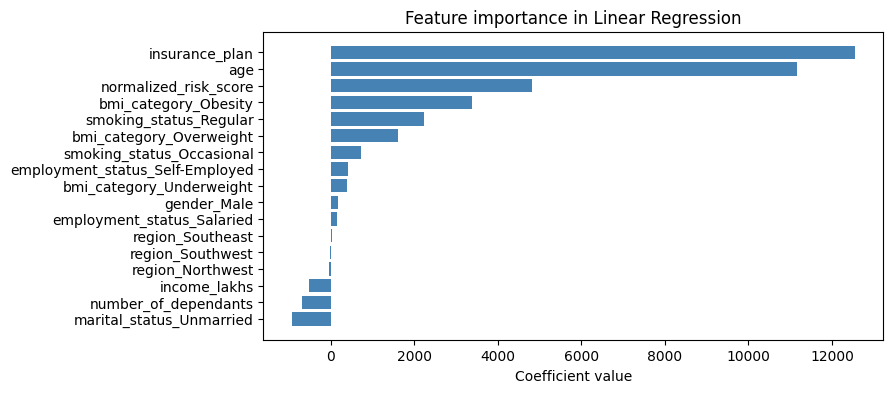

In [177]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient",ascending=True)

py.figure(figsize=(8,4))
py.barh(coef_df.index,coef_df["Coefficient"],color="steelblue")
py.title("Feature importance in Linear Regression")
py.xlabel("Coefficient value")
py.show()


In [178]:
model_ridge = Ridge()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.9282143198366275, 0.9280541644640345)

In [180]:
model_ridge = Lasso()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.928211327505007, 0.9280870828363261)

In [183]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,Y_train)
test_score = model_xgb.score(X_test,Y_test)
train_score = model_xgb.score(X_train,Y_train)
train_score,test_score

(0.9860964417457581, 0.9809534549713135)

In [186]:
model_xgb = XGBRegressor()

param_grid = {
    "n_estimators":[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
}

random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,Y_train)
random_search.best_score_

np.float64(0.9809474547704061)

In [187]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [188]:
best_model = random_search.best_estimator_

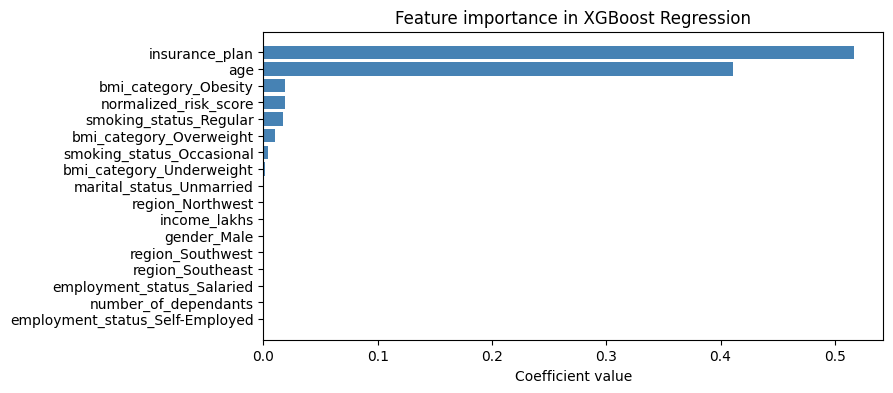

In [189]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient",ascending=True)

py.figure(figsize=(8,4))
py.barh(coef_df.index,coef_df["Coefficient"],color="steelblue")
py.title("Feature importance in XGBoost Regression")
py.xlabel("Coefficient value")
py.show()


### Error Analysis

In [195]:
y_pred = best_model.predict(X_test)

residuals = y_pred-Y_test
residual_pct = residuals*100/Y_test


results_df = pd.DataFrame({
    'actual':Y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residual_pct
})

residual_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

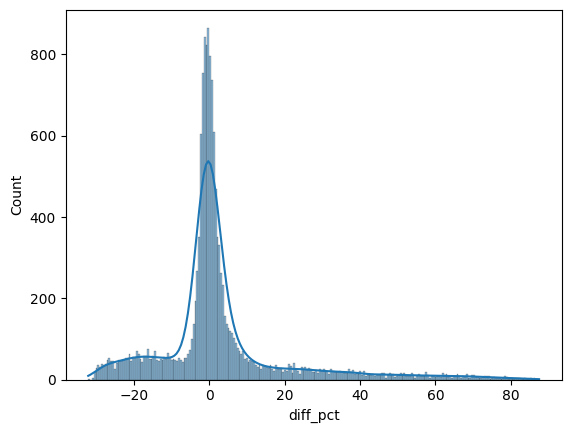

In [196]:
sns.histplot(residual_df["diff_pct"],kde=True)

In [204]:
extreme_error_threshold = 10
extreme_result_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

In [205]:
extreme_result_df.shape

(4487, 4)

In [206]:
extreme_error_pct = extreme_result_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.967274427302478

In [207]:
extreme_result_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [209]:
extreme_errors_df = X_test.loc[extreme_result_df.index]
extreme_errors_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.018519,0.2,0.070707,0.0,0.000000,0,0,1,0,1,0,0,0,0,0,0,0
25179,0.129630,0.0,0.111111,0.0,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
21592,0.055556,0.0,0.060606,0.5,0.000000,1,0,0,0,1,0,0,0,0,1,0,0
49274,0.055556,0.2,0.070707,0.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0


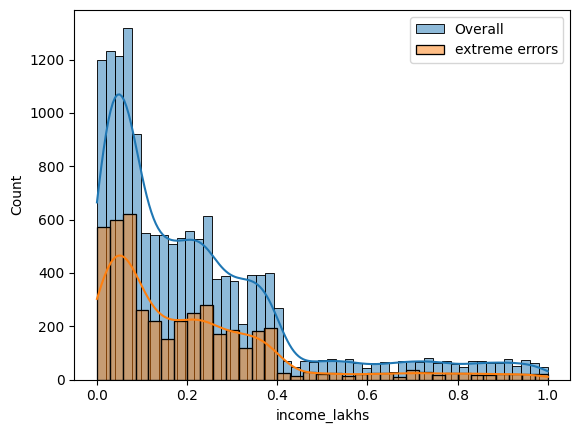

In [211]:
sns.histplot(X_test.income_lakhs,label="Overall",kde=True)
sns.histplot(extreme_errors_df.income_lakhs,label="extreme errors",kde=True)
py.legend()
py.show()

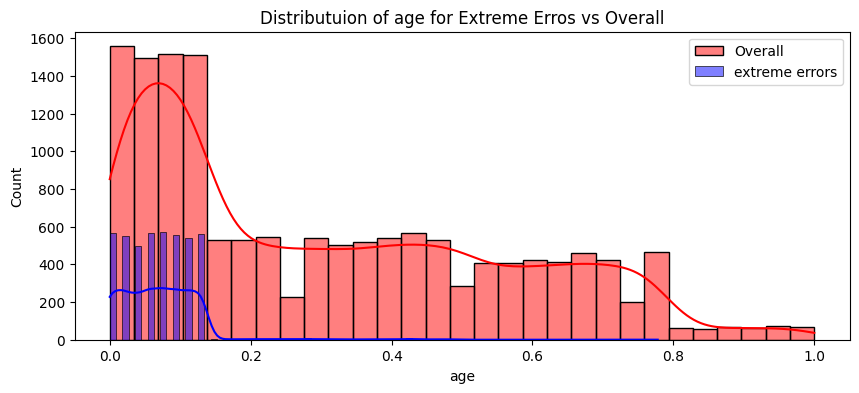

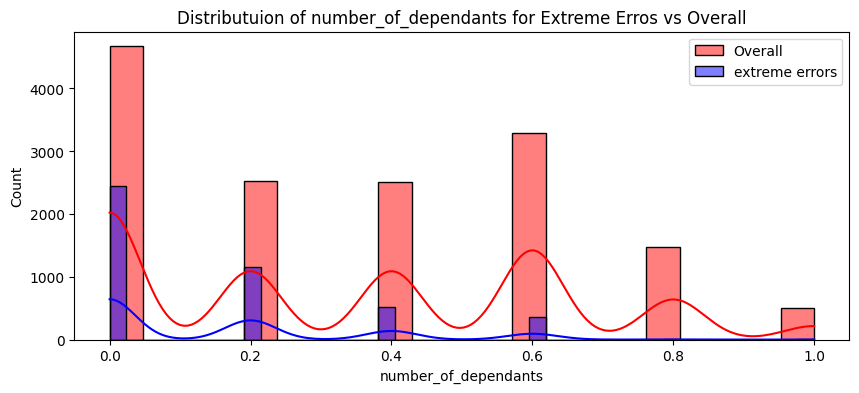

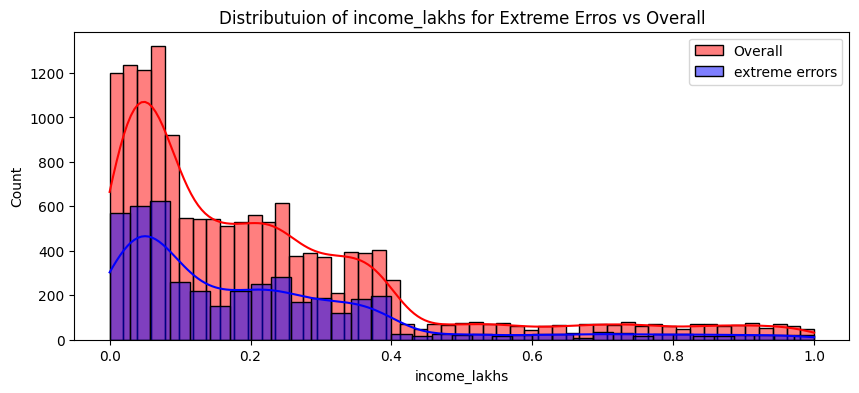

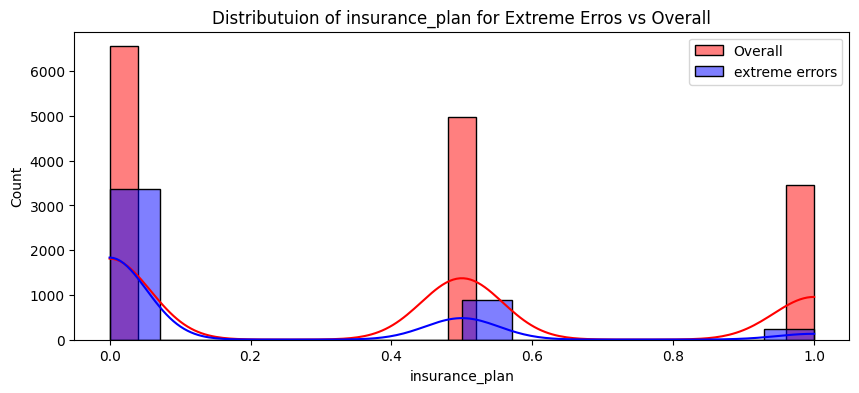

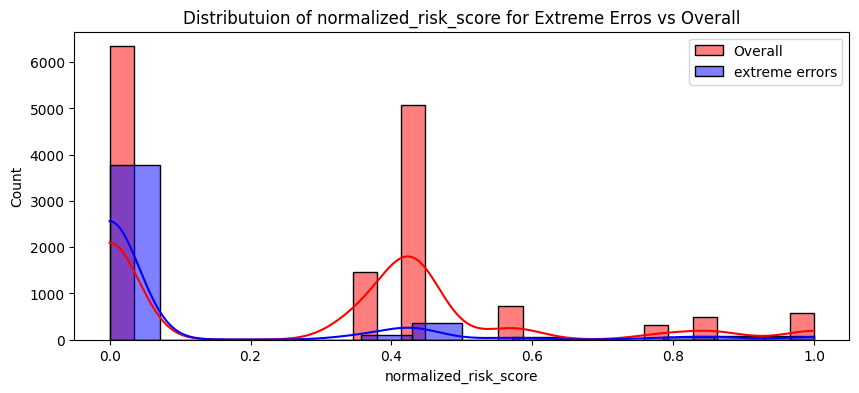

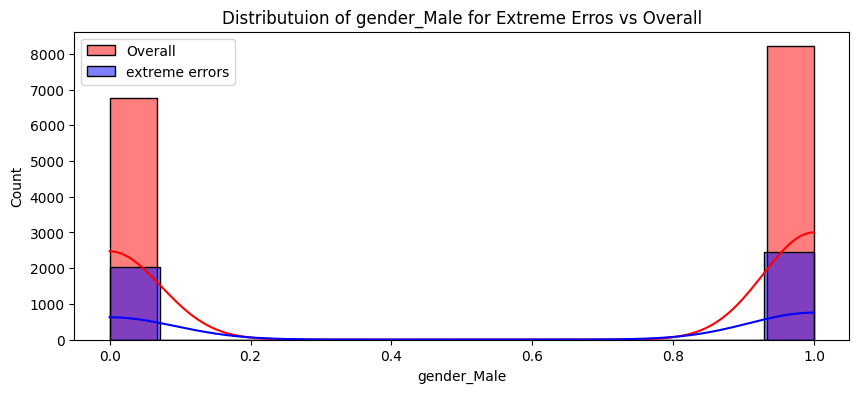

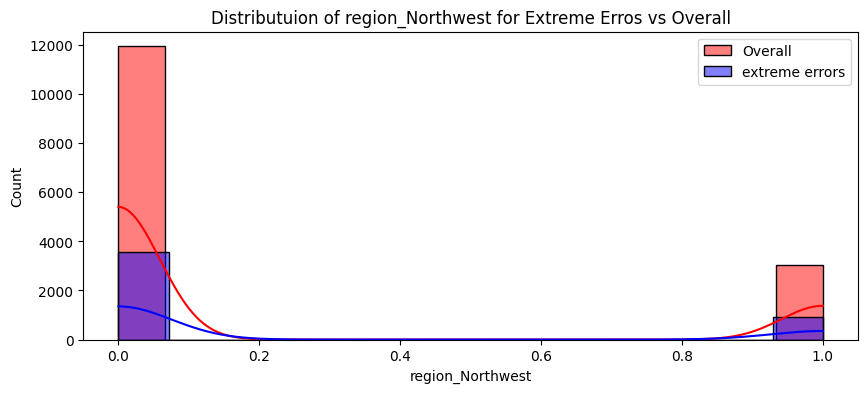

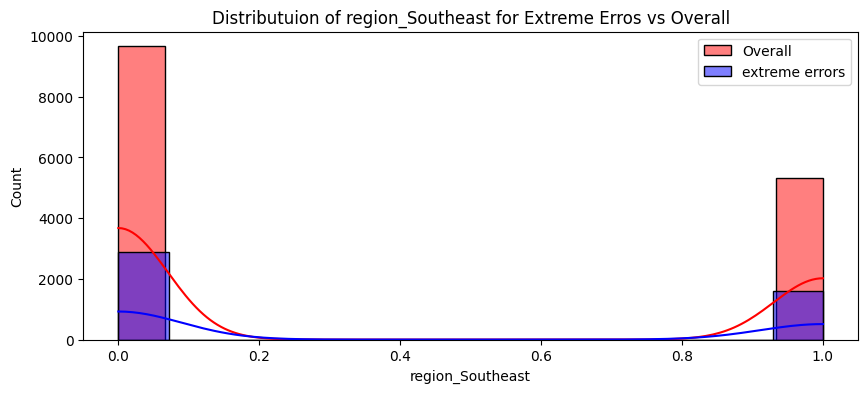

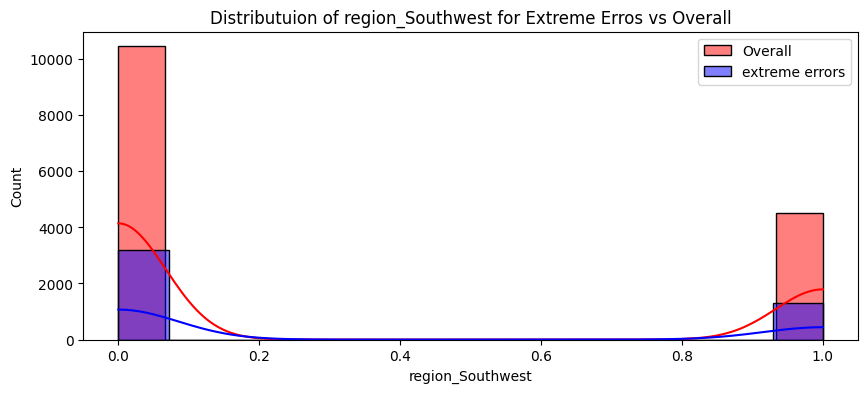

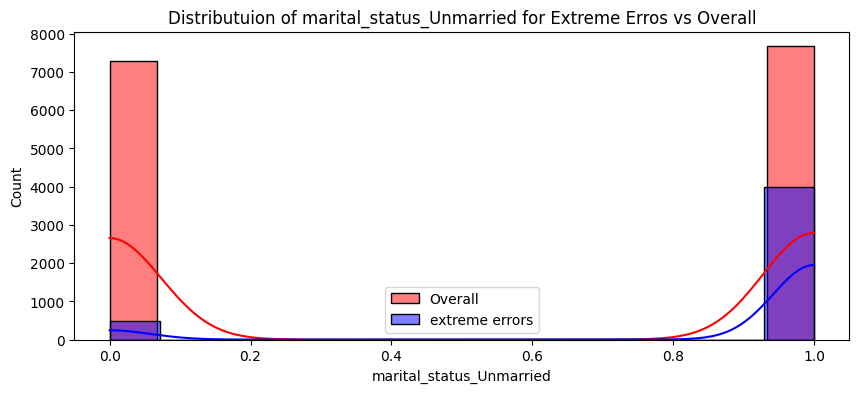

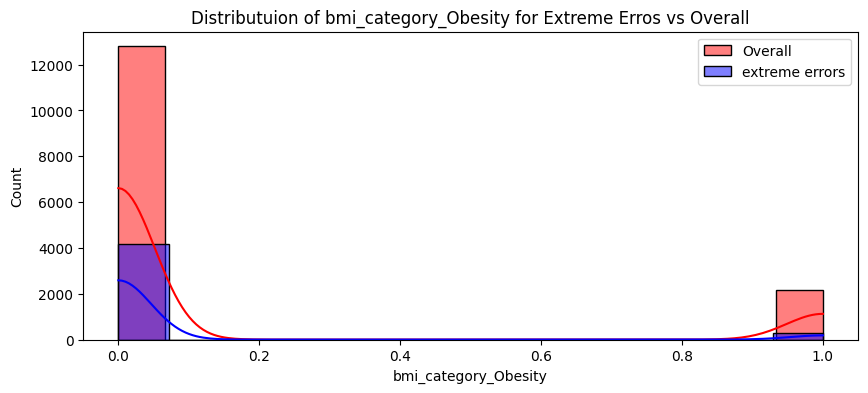

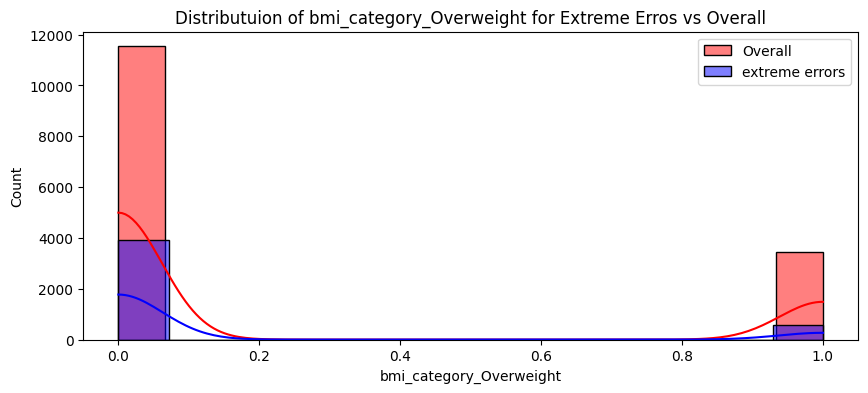

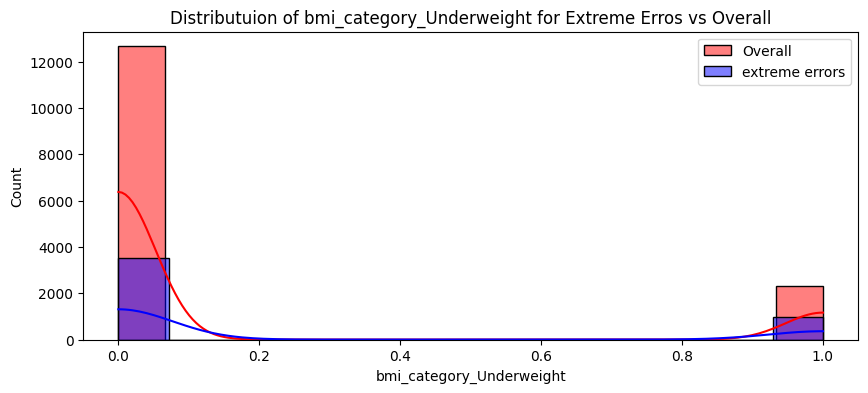

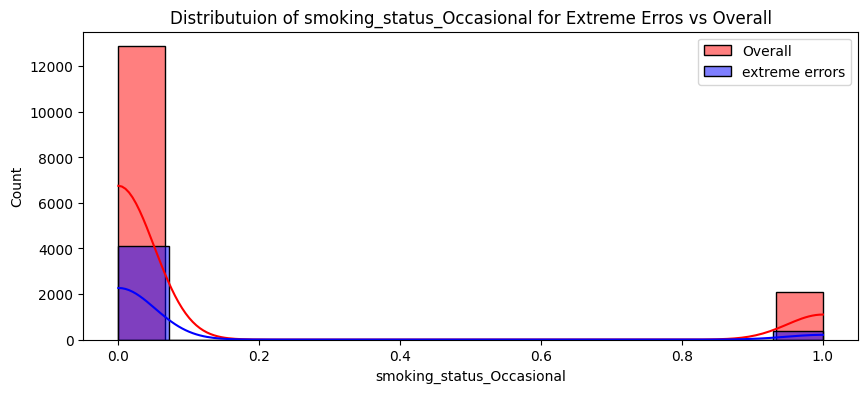

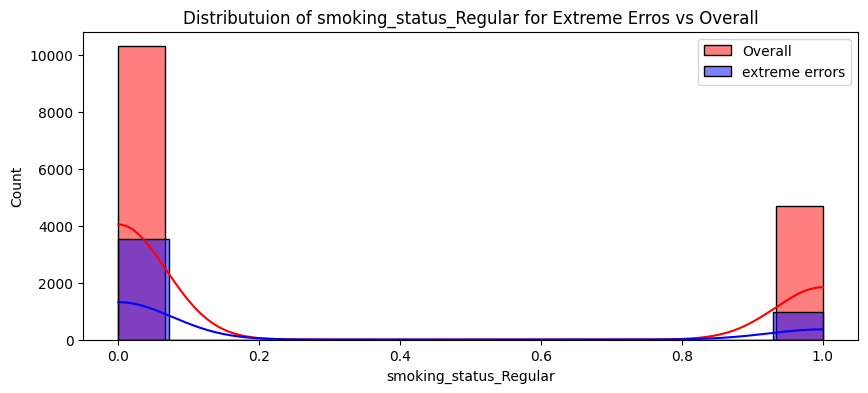

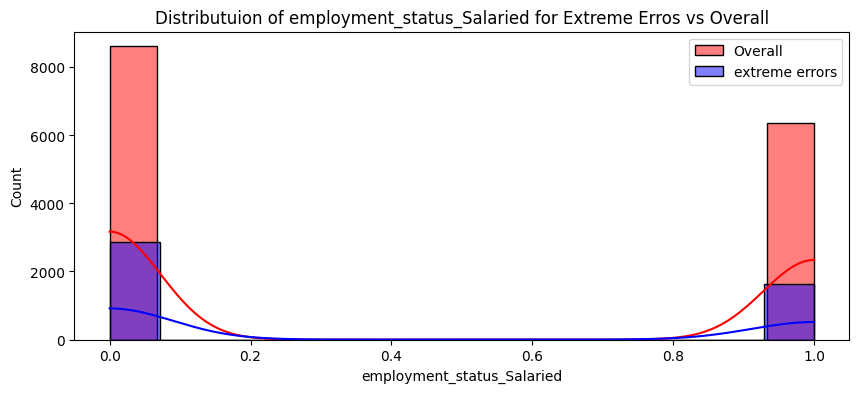

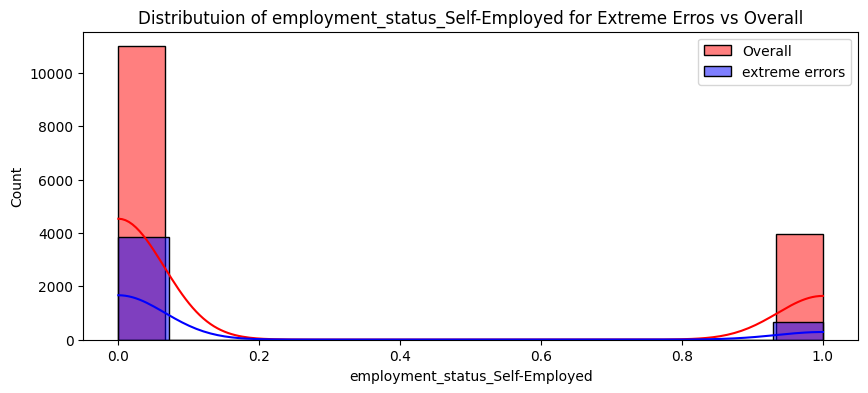

In [217]:
for feature in X_test.columns:
    py.figure(figsize=(10,4))
    sns.histplot(X_test[feature],label="Overall",color="red",kde=True)
    sns.histplot(extreme_errors_df[feature],color="blue",label="extreme errors",kde=True)
    py.legend()
    py.title(f"Distributuion of {feature} for Extreme Erros vs Overall")
    py.show()

<Axes: xlabel='age', ylabel='Count'>

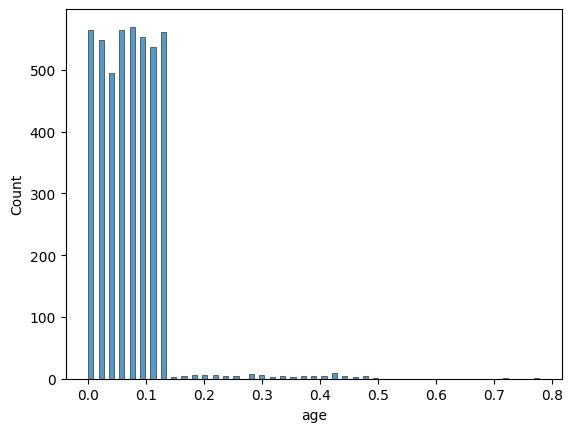

In [218]:
sns.histplot(extreme_errors_df.age)

In [221]:
extreme_errors_df["income_level"]=-1

<Axes: xlabel='age', ylabel='Count'>

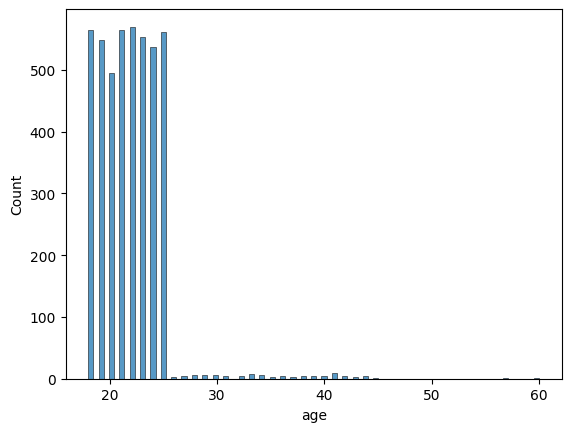

In [223]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = age_original = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed["age"])

In [224]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000
